# Denoising AutoEncoder

1. CNN+AE
2. CNN+AE+BatchNorm
3. CNN+AE+SSIMLoss

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction

## 学習データ作成

old Sensr Data

In [14]:

# Dataset = dataset.dataset("Obrid_AE", "data")
# Dataset.concat_data("sample_data",500)
# Dataset = dataset.dataset("Obrid_AE", "test")
# print("----------------------")
# Dataset.concat_data("sample_test",100)
# print("----------------------")
# data = Dataset.read_savedata("sample_test")
# print(data.shape[0])
# print("----------------------")
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 128, 1)


## New Sensor Data

In [15]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 500
epochSizeStr = 1000
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)


1339 0
rate 0.9
data.shape[0]: 7202
rate 6481
TrainData (1000, 256, 1, 1, 256)
TestData (721, 256)
ÄnomalyDta (191, 256)


## モデル学習

Denoise AE


In [16]:

losslist=[]
#model
model_CnnAE = mainmodel.Autoencoder_cnn()#model1
model_norm = mainmodel.Autoencoder_batchnorm()#model2
#loss
criterion_mse = nn.MSELoss()
criterion_ssim = LossFunction.SSIMLoss()

model = model_norm
criterion = criterion_mse

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
input = torch.from_numpy(data.astype(np.float32)).clone()
ori_input = torch.from_numpy(ori_data.astype(np.float32)).clone()
cnt = 0
for (epoch, epoch_ori) in zip(input, ori_input):
    cnt+=1
    for (x, y) in zip(epoch, epoch_ori):
        recon = model(x)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:{}, Loss:{:.4f}'.format(cnt, float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

make
epoch:1, Loss:0.1877
epoch:2, Loss:0.0824
epoch:3, Loss:0.1053
epoch:4, Loss:0.0276
epoch:5, Loss:0.0688
epoch:6, Loss:0.0488
epoch:7, Loss:0.0301
epoch:8, Loss:0.0296
epoch:9, Loss:0.0273
epoch:10, Loss:0.0110
epoch:11, Loss:0.0115
epoch:12, Loss:0.0187
epoch:13, Loss:0.0102
epoch:14, Loss:0.0068
epoch:15, Loss:0.0046
epoch:16, Loss:0.0035
epoch:17, Loss:0.0031
epoch:18, Loss:0.0111
epoch:19, Loss:0.0040
epoch:20, Loss:0.0042
epoch:21, Loss:0.0017
epoch:22, Loss:0.0023
epoch:23, Loss:0.0015
epoch:24, Loss:0.0027
epoch:25, Loss:0.0084
epoch:26, Loss:0.0289
epoch:27, Loss:0.0041
epoch:28, Loss:0.0031
epoch:29, Loss:0.0017
epoch:30, Loss:0.0374
epoch:31, Loss:0.0237
epoch:32, Loss:0.0412
epoch:33, Loss:0.0017
epoch:34, Loss:0.0008
epoch:35, Loss:0.0037
epoch:36, Loss:0.0011
epoch:37, Loss:0.0022
epoch:38, Loss:0.0033
epoch:39, Loss:0.0036
epoch:40, Loss:0.0043
epoch:41, Loss:0.0050
epoch:42, Loss:0.0032
epoch:43, Loss:0.0016
epoch:44, Loss:0.0068
epoch:45, Loss:0.0055
epoch:46, Loss

## モデルの保存

In [17]:
folder_name = "newSensor"
model_name = "Denoising_AE_CNN"+"epoch_"+str(epoch)+"epockSize_"+str(epochSizeStr)
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model)

## 結果の確認

<class 'torch.Tensor'>


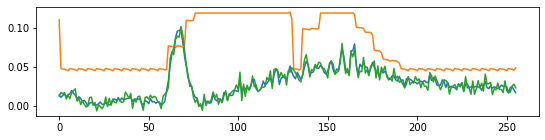

normal:12.377043722197413
anomaly


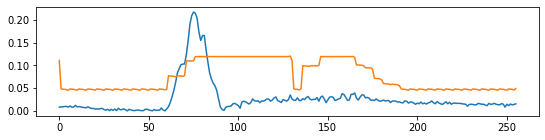

anomarly:14.19190146587789
anomaly
<class 'torch.Tensor'>


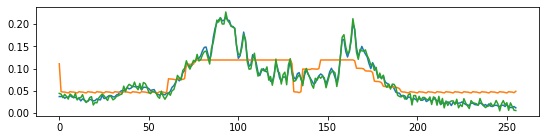

normal:6.0216992273926735


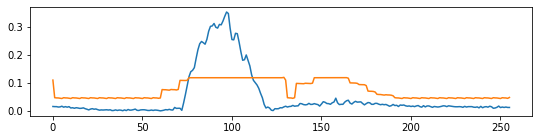

anomarly:15.598220298066735
anomaly
<class 'torch.Tensor'>


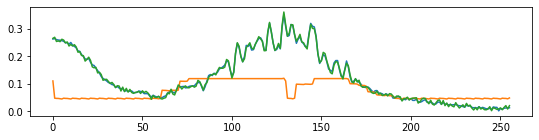

normal:16.087188743054867
anomaly


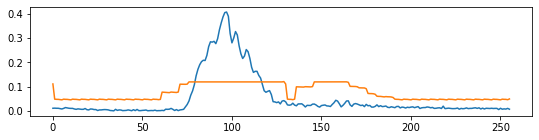

anomarly:16.38011677749455
anomaly
<class 'torch.Tensor'>


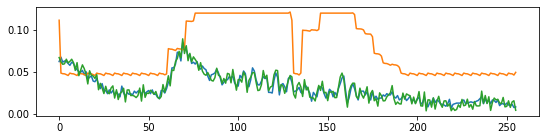

normal:11.89553352445364
anomaly


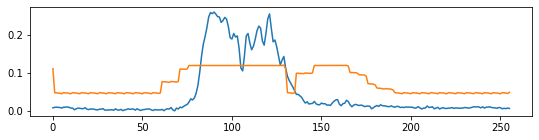

anomarly:14.90681442245841
anomaly
<class 'torch.Tensor'>


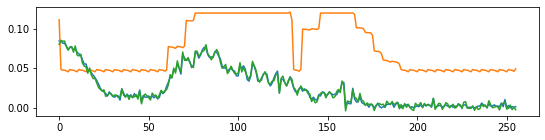

normal:13.780947666615248
anomaly


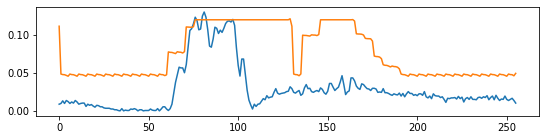

anomarly:12.117040734738111
anomaly
<class 'torch.Tensor'>


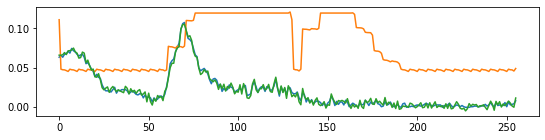

normal:14.84127519465983
anomaly


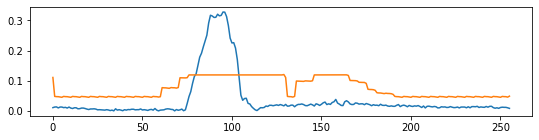

anomarly:16.222262121737003
anomaly
<class 'torch.Tensor'>


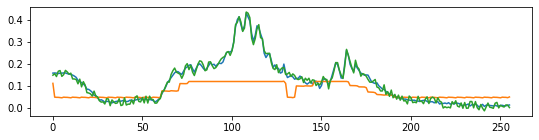

normal:14.820789907127619
anomaly


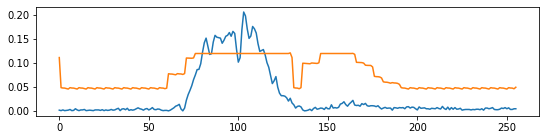

anomarly:13.909718871116638
anomaly
<class 'torch.Tensor'>


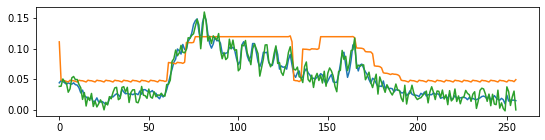

normal:7.029818253591657


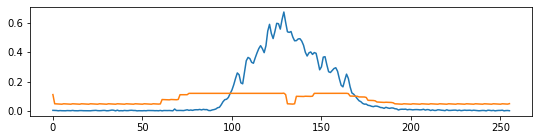

anomarly:27.88170440122485
anomaly
<class 'torch.Tensor'>


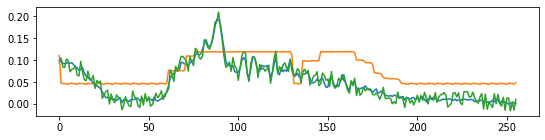

normal:9.436888489872217


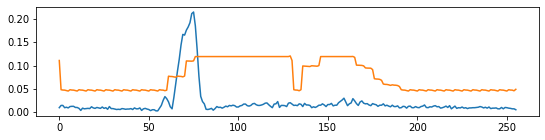

anomarly:15.857941310852766
anomaly
<class 'torch.Tensor'>


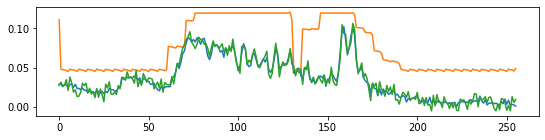

normal:10.29927172511816
anomaly


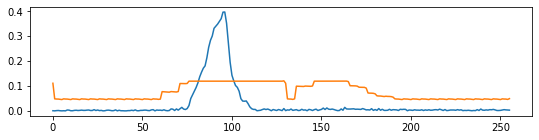

anomarly:18.265147265046835
anomaly
<class 'torch.Tensor'>


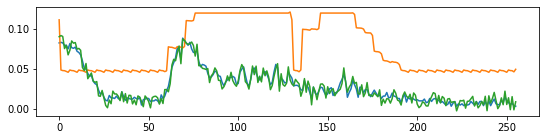

normal:13.087008524686098
anomaly


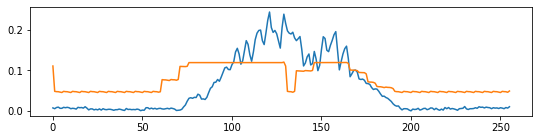

anomarly:11.903159085661173
anomaly
<class 'torch.Tensor'>


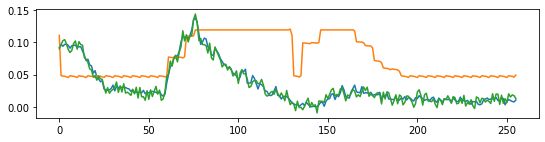

normal:12.571730153635144
anomaly


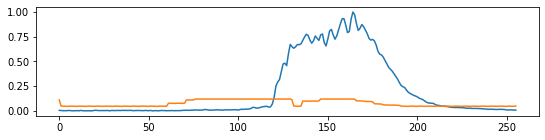

anomarly:51.53289479576051
anomaly
<class 'torch.Tensor'>


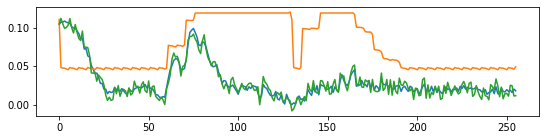

normal:13.167927475646138
anomaly


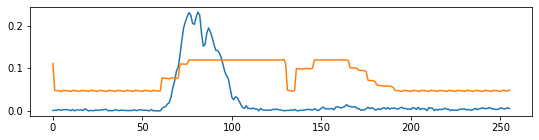

anomarly:16.47668942064047
anomaly
<class 'torch.Tensor'>


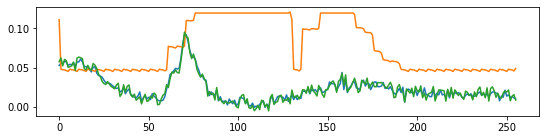

normal:13.59473180025816
anomaly


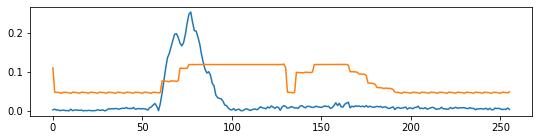

anomarly:16.61432932317257
anomaly
<class 'torch.Tensor'>


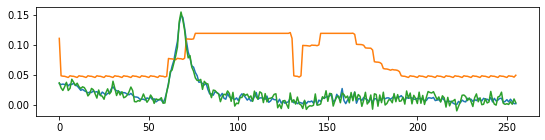

normal:15.5644949991256
anomaly


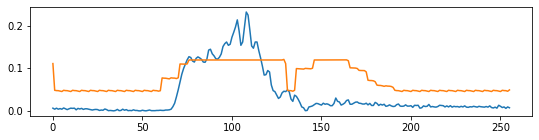

anomarly:12.507645767182112
anomaly
<class 'torch.Tensor'>


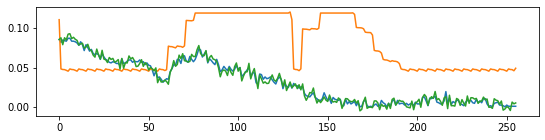

normal:13.367526073008776
anomaly


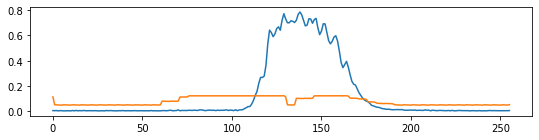

anomarly:37.21120208501816
anomaly
<class 'torch.Tensor'>


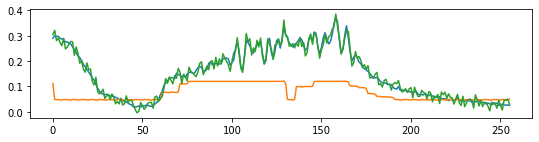

normal:20.527033435180783
anomaly


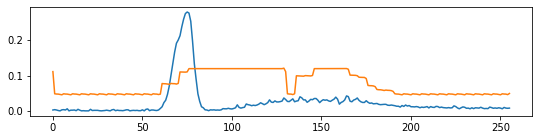

anomarly:16.10604701563716
anomaly
<class 'torch.Tensor'>


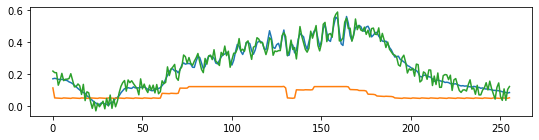

normal:45.11246368102729
anomaly


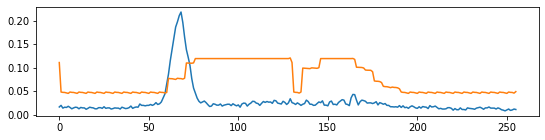

anomarly:14.354239095002413
anomaly
<class 'torch.Tensor'>


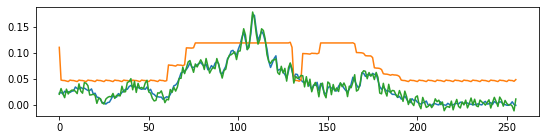

normal:9.924052309244871


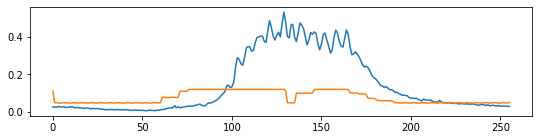

anomarly:26.911717914044857
anomaly
<class 'torch.Tensor'>


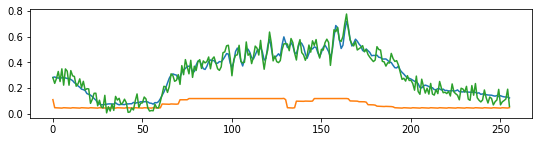

normal:60.97595037147403
anomaly


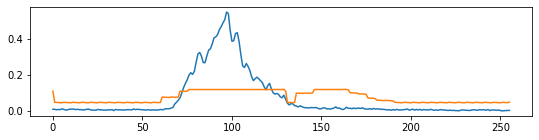

anomarly:19.32291356101632
anomaly


In [18]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 10 == 0:

        
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
            ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
            # ori_input0 =  ori_data[i]
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            print(type(data0))
            plt.figure(figsize=(9, 2))
            # data = data0.numpy()
            ori_input0 = ori_input0[i, :, :, :]
            input0 = input0[i, :, :, :]
            recon = model(ori_input0).detach().numpy()
            ori_input0 = ori_input0[0, 0, :]
            input0 = input0[0, 0, :]
            plt.plot(ori_input0)
            plt.plot(recon.flatten())
            plt.plot(input0)
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-ori_input0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            plt.figure(figsize=(9, 2))
            # data = test0.numpy()
            ano_data = test0[np.newaxis, np.newaxis, :]
            recon = model(ano_data).detach().numpy()
            plt.plot(test0.numpy(),label="testdata")
            plt.plot(recon.flatten(),label="recondata")
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError:
            print("Finish")
            break

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

# OCSVM

In [8]:
import dataloader
#OCSVM用データセットロード
Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)
#モデルの読み込み必要なら
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth"
input_model = mainmodel.Autoencoder_cnn()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder_cnn().to(device)
input_model.load_state_dict(torch.load(model_name, map_location=device))

# input_model = model
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data'

## 可視化

y_pred_train:450 
y_pred_anomaly:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1] 
y_pred_outliers:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 


/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_3682/2985198829.py:62: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_3682/2985198829.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


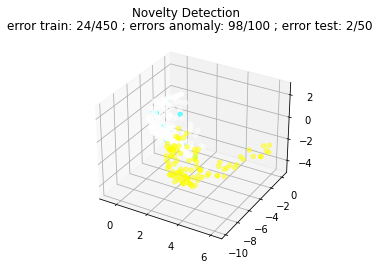

In [ ]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()